# Medicare Funnel Analysis

This project analyses lead to app conversion rates to identify the top agents and to identify factors that make them successful. The dataset simulated real-world insurance sales activity, and the goal was to analyze agent performance, sales pipeline velocity, and quota alignment.
                           
#### Key Definitions							
- Agent: licensed insurance agent, authorized to make sales calls to potential customers & submit policies to carriers on their behalf							
- Agent ramp: experience level of the sales agent, starting with ramps 0 through 3 and ending with tenure							
- Quota: agents' sales expectations for a given month, specific to products and agent tenure							
- Lead: potential customer has inquired online about enrolling in Medicare coverage							
- Contact: an agent has made contact with a customer in an attempt to make a sale							
- Quote: agent has provided customer with quoted price on a potential Medicare plan							
- Application: agent has submitted an application to an insurance carrier on behalf of the customer							


#### Project Instructions	
This dataset provides an example of the type of data you might be working with. We would like you to utilize this to generate a report to showcase key performance indicators (KPIs) of our sales production. The goal is to identify trends and extract key takeaways from the dataset and the reports you create. You are welcome to use any tools, build additional helper tables or applications, but please be prepared to demonstrate your work or explain your methodology and conclusions.	
					
Be able to answer key questions such as:						
1. What do you consider the most important key performance indicator (KPI), and why?						
2. Who are the top performers and what are the key factors contributing to their success?						
3. Are some leads of higher quality than others? Explain your justification.						
4. What strategies should we implement to increase production?	

## Analysis Overview

This analysis focuses on
- Funnel Efficiency
- Agent Performance
- Process Velocity

## The Data

#### Import packages, create dataframes.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt
from scipy.stats import pearsonr


xl = pd.ExcelFile("data/2025 BA Systems Analyst Project.xlsx")
agents = xl.parse("agent_data")
quota = xl.parse("agent_quota")
leads = xl.parse("marketing_leads")
quotes = xl.parse("quotes")
apps = xl.parse("applications")

### Quota date range is August 2022 to September 2022

In [38]:
min_start_date = quota['start_date'].min()
max_end_date = quota['end_date'].max()

print(f"Date range: {min_start_date} to {max_end_date}")

Date range: 2022-08-01 00:00:00 to 2022-09-30 00:00:00


### Application date range is August 2022 to September 2022

In [39]:
min_app_start_date = apps['submitted_timestamp'].min()
max_app_end_date = apps['submitted_timestamp'].max()

print(f"Date range: {min_app_start_date} to {max_app_end_date}")

Date range: 2022-08-01 09:20:53 to 2022-09-30 16:48:37


### 28 active agents from August 2022 to September 2022

In [40]:
# Define the analysis start date
analysis_start = pd.to_datetime('2022-08-01')

# Keep agents who are either:
# - still active (term_date is NaT)
# - OR terminated **after** the analysis start
active_agents = agents[
    (agents['term_date'].isna()) | (agents['term_date'] >= analysis_start)
]

agents = active_agents.copy()

In [41]:
agents = agents.rename(columns={'id': 'agent_id'})
agents.head()

,agent_id,agent_name,agent_ramp,business,start_date,term_date,login_email
0,657313,Abigail Harris,ramp_1,MA,2022-06-17,NaT,abigail.harris@smartmatch.com
1,657257,Alexander Moore,ramp_1,MA,2022-06-03,NaT,alexander.moore@smartmatch.com
2,657195,Amelia Anderson,tenured,MA,2022-05-20,NaT,amelia.anderson@smartmatch.com
3,656360,Ava Jones,ramp_2,MA,2021-06-21,NaT,ava.jones@smartmatch.com
4,657431,Avery Scott,ramp_1,MA,2022-07-04,NaT,avery.scott@smartmatch.com


In [67]:
agents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, 0 to 29
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   agent_id     28 non-null     int64         
 1   agent_name   28 non-null     object        
 2   agent_ramp   28 non-null     object        
 3   business     28 non-null     object        
 4   start_date   28 non-null     datetime64[ns]
 5   term_date    3 non-null      datetime64[ns]
 6   login_email  28 non-null     object        
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 1.8+ KB


In [42]:
# Create mapping from cleaned agent name to agent_id in quotes DataFrame (all other DataFrames use agent_id directly, quota df uses ramp_month_code / agent_ramp)
name_to_id = dict(
    zip(
        agents['agent_name'].str.strip().str.lower(),
        agents['agent_id']
    )
)

# avoids modifying the original DataFrame, avoids SettingWithCopyWarning
quotes = quotes.copy()
quotes['name_clean'] = quotes['agent_name'].str.strip().str.lower()
quotes['agent_id'] = quotes['name_clean'].map(
    name_to_id)  # uses the dictionary to map names to IDs
quotes = quotes.rename(columns={'created_date': 'quote_created_date'})

quotes.head()

,agent_sf_id,agent_name,quote_id,product_name,quote_created_date,lead_id,name_clean,agent_id
0,0052E00000MyQdbQAF,Olivia Smith,0Q02E000006Iv5XSAS,Medicare Advantage,2022-08-01 14:00:46,22998260.0,olivia smith,655564
1,0052E00000MyQdbQAF,Olivia Smith,0Q02E000006IvdZSAS,Medicare Advantage,2022-08-01 17:21:34,NaN,olivia smith,655564
2,0052E00000MyQdbQAF,Olivia Smith,0Q02E000006IvY5SAK,Medicare Advantage,2022-08-01 16:48:47,23002384.0,olivia smith,655564
3,0052E00000MyQdbQAF,Olivia Smith,0Q02E000006Iw6gSAC,Medicare Advantage,2022-08-02 10:22:04,23007330.0,olivia smith,655564
4,0052E00000MyQdbQAF,Olivia Smith,0Q02E000006IwYaSAK,Medicare Advantage,2022-08-02 12:52:00,23010891.0,olivia smith,655564


In [64]:
quotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1789 entries, 0 to 1788
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   agent_sf_id         1789 non-null   object        
 1   agent_name          1789 non-null   object        
 2   quote_id            1789 non-null   object        
 3   product_name        1789 non-null   object        
 4   quote_created_date  1789 non-null   datetime64[ns]
 5   lead_id             1749 non-null   float64       
 6   name_clean          1789 non-null   object        
 7   agent_id            1789 non-null   int64         
 8   product_key         1789 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 125.9+ KB


In [65]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1226 entries, 0 to 1225
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   agent_sf_id          1226 non-null   object        
 1   agent_id             1226 non-null   int64         
 2   application_id       1226 non-null   object        
 3   product_name         1226 non-null   object        
 4   submitted_timestamp  1226 non-null   datetime64[ns]
 5   lead_id              1188 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 57.6+ KB


In [69]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110887 entries, 0 to 110886
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   lead_id                 110887 non-null  int64         
 1   cost                    110887 non-null  float64       
 2   applicable_cost_status  110887 non-null  object        
 3   lead_source             110887 non-null  object        
 4   lead_creation_date      110887 non-null  datetime64[ns]
 5   contact_timestamp       8233 non-null    object        
 6   agent_id                8233 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 5.9+ MB


### 3 products: Medicare Advantage, Medicare Supplement and Dental Vision Hearing

In [43]:
print(quotes.product_name.unique())

['Medicare Advantage' 'Medicare Supplement' 'Dental Vision Hearing']


#### Leaving quotes with missing lead information in place because they represent a tiny fraction of quotes and will not significantly skew aggregate results.

In [44]:
print(quotes.shape)
missing_count = quotes['lead_id'].isna().sum()
print(f"{missing_count} quotes are missing lead information.")
print(round(40/1789, 2), "% of quotes are missing lead information.")

(1789, 8)
40 quotes are missing lead information.
0.02 % of quotes are missing lead information.


In [45]:
quota.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   start_date       27 non-null     datetime64[ns]
 1   end_date         27 non-null     datetime64[ns]
 2   product          27 non-null     object        
 3   role_id          27 non-null     int64         
 4   ramp_month_code  27 non-null     object        
 5   sales_quota      27 non-null     int64         
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 1.4+ KB


In [46]:
quota.head()

,start_date,end_date,product,role_id,ramp_month_code,sales_quota
0,2022-08-01,2022-08-31,Dental Vision Hearing,78,ramp_1,2
1,2022-08-01,2022-08-31,Dental Vision Hearing,78,ramp_2,3
2,2022-08-01,2022-08-31,Dental Vision Hearing,78,ramp_3,3
3,2022-08-01,2022-08-31,Dental Vision Hearing,78,tenured,4
4,2022-08-01,2022-08-31,Medicare Advantage,78,ramp_1,18


In [47]:
leads.head()

,lead_id,cost,applicable_cost_status,lead_source,lead_creation_date,contact_timestamp,agent_id
0,22990524,88.47,YES,Aster_Arch,2022-08-01 00:48:43,NaN,NaN
1,22990531,1.75,YES,Fern_Fringe,2022-08-01 01:23:31,NaN,NaN
2,22990538,0.01,YES,Vanilla_Velvet,2022-08-01 01:39:53,NaN,NaN
3,22990549,134.45,YES,Thyme_Thread,2022-08-01 02:20:19,NaN,NaN
4,22990550,0.00,YES,Lilac_Lantern,2022-08-01 02:32:06,NaN,NaN


In [48]:
leads.dtypes

lead_id                            int64
cost                             float64
applicable_cost_status            object
lead_source                       object
lead_creation_date        datetime64[ns]
contact_timestamp                 object
agent_id                         float64
dtype: object

In [49]:
apps.head()

,agent_sf_id,agent_id,application_id,product_name,submitted_timestamp,lead_id
0,0052E00000MyQdbQAF,655564,a012E00000uMcjaQAC,Medicare Advantage,2022-08-01 14:02:30,22998260.0
1,0052E00000MyQdbQAF,655564,a012E00000uMd6ZQAS,Medicare Advantage,2022-08-01 16:50:26,23002384.0
2,0052E00000MyQdbQAF,655564,a012E00000uMdARQA0,Medicare Advantage,2022-08-01 17:24:05,NaN
3,0052E00000MyQdbQAF,655564,a012E00000uMdT0QAK,Medicare Advantage,2022-08-02 10:26:59,23007330.0
4,0052E00000MyQdbQAF,655564,a012E00000uMeDrQAK,Medicare Advantage,2022-08-02 16:39:01,23015883.0


## Agent Performance

### Agent product quotas by month

In [50]:
# Given an agent’s ramp level (like ramp_1), find all the relevant quotas for that level, and expand them into one row per product per month.
# agent_quotas = agents.merge(
#     quota, left_on='agent_ramp', right_on='ramp_month_code')

# Clean column names
quota.columns = quota.columns.str.lower().str.strip()

# Convert date columns to datetime
quota['start_date'] = pd.to_datetime(quota['start_date'])
quota['end_date'] = pd.to_datetime(quota['end_date'])

# Expand quotas for each agent by matching ramp code
quota_expanded = []

for _, agent_row in agents.iterrows():
    agent_name = agent_row['agent_name']
    agent_ramp = agent_row['agent_ramp']
    # Find all quota rows for this ramp code
    # filter quotas for the current agent's ramp level
    agent_quotas = quota[quota['ramp_month_code'] == agent_ramp]
    for _, quota_row in agent_quotas.iterrows():  # loop through each quota row for the agent
        # Create a period range for the start and end dates of the quota
        # This will create a monthly period for each month in the quota's date range
        # e.g., if the quota is from 2025-01-01 to 2025-03-31, it will create periods for Jan, Feb, and Mar
        # The period is created using 'MS' frequency which stands for Month Start
        # This means the period will start at the beginning of each month
        # The period will be in the format YYYY-MM, e.g., 2025- 01, 2025-02, 2025-03
        # This will create a list of periods for each month in the quota's date range
        period = pd.date_range(
            start=quota_row['start_date'], end=quota_row['end_date'], freq='MS')
        for month in period:
            quota_expanded.append({
                'agent_name': agent_name,
                'product_name': quota_row['product'],
                'month': month.to_period('M'),
                'sales_quota': quota_row['sales_quota']
            })

# Final quota_clean DataFrame
quota_clean = pd.DataFrame(quota_expanded)

quota_clean.head(6)

,agent_name,product_name,month,sales_quota
0,Abigail Harris,Dental Vision Hearing,2022-08,2
1,Abigail Harris,Medicare Advantage,2022-08,18
2,Abigail Harris,Medicare Supplement,2022-08,1
3,Abigail Harris,Dental Vision Hearing,2022-09,2
4,Abigail Harris,Medicare Advantage,2022-09,13
5,Abigail Harris,Medicare Supplement,2022-09,0


In [51]:
for idx, row in agents.head(2).iterrows():
    print(f"Row {idx}: {row['agent_name']} is in {row['agent_ramp']}")

Row 0: Abigail Harris is in ramp_1
Row 1: Alexander Moore is in ramp_1


### Application counts by agent and product

In [52]:
# Merge agent_name into apps
apps_with_names = apps.merge(
    agents[['agent_id', 'agent_name']], on='agent_id', how='left')

# Add month column if not present
if 'month' not in apps_with_names.columns:
    apps_with_names['month'] = apps_with_names['submitted_timestamp'].dt.to_period(
        'M')

app_counts = (
    apps_with_names
    .groupby(['agent_name', 'product_name', 'month'], as_index=False)
    .size()  # counts rows in each group
    # changes the count column's name from size to app_count
    .rename(columns={'size': 'app_count'})
)

app_counts.head()

,agent_name,product_name,month,app_count
0,Abigail Harris,Dental Vision Hearing,2022-08,5
1,Abigail Harris,Dental Vision Hearing,2022-09,8
2,Abigail Harris,Medicare Advantage,2022-08,7
3,Abigail Harris,Medicare Advantage,2022-09,11
4,Alexander Moore,Dental Vision Hearing,2022-08,3


### Agent performance: quotas--> submitted applications

In [53]:
performance = (
    quota_clean
    .merge(app_counts, on=['agent_name', 'product_name', 'month'], how='left')
    .fillna({'app_count': 0})   # fill missing app counts with 0
)

performance.head(10)

,agent_name,product_name,month,sales_quota,app_count
0,Abigail Harris,Dental Vision Hearing,2022-08,2,5.0
1,Abigail Harris,Medicare Advantage,2022-08,18,7.0
2,Abigail Harris,Medicare Supplement,2022-08,1,0.0
3,Abigail Harris,Dental Vision Hearing,2022-09,2,8.0
4,Abigail Harris,Medicare Advantage,2022-09,13,11.0
5,Abigail Harris,Medicare Supplement,2022-09,0,0.0
6,Alexander Moore,Dental Vision Hearing,2022-08,2,3.0
7,Alexander Moore,Medicare Advantage,2022-08,18,8.0
8,Alexander Moore,Medicare Supplement,2022-08,1,0.0
9,Alexander Moore,Dental Vision Hearing,2022-09,2,1.0


### Total Applications by Agent vs Tenure/Quotas
This chart shows the total number of applications submitted by agent.  An agent's tenure/quotas are a poor predictor of total applications submitted.

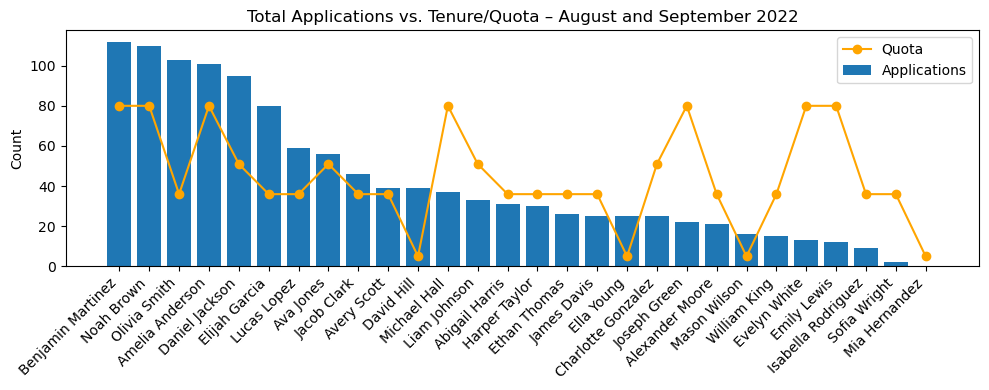

In [54]:
# Group totals by agent_name
totals = (
    performance                       # no month filter
    .groupby('agent_name', as_index=False)[['sales_quota', 'app_count']]
    .sum()
    .sort_values('app_count', ascending=False)
)

# Plot bar for applications, line for quota
plt.figure(figsize=(10, 4))
plt.bar(totals['agent_name'], totals['app_count'], label='Applications')
plt.plot(totals['agent_name'], totals['sales_quota'],
         color='orange', marker='o', label='Quota')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.title('Total Applications vs. Tenure/Quota – August and September 2022')
plt.legend()
plt.tight_layout()
plt.savefig('figures/total_apps_vs_tenure_agent.png', dpi=300)
plt.show()

Tenure influences success, but does not guarantee it.
- There is some overlap between tenure and top performance: many of the top agents are tenured or assigned higher quotas.
- However, not all tenured agents are top performers, and not all high performers are tenured — some succeed early in their ramp phase.
- This suggests that while experience and expectation (quotas) may contribute, they are not strong predictors on their own.

## Funnel Metrics

In [55]:


# count the number of leads, contacted leads, quotes given, and applications
lead_cnt = len(leads)                              # all rows
contacted_cnt = leads['contact_timestamp'].notna().sum()
quotes_cnt = len(quotes)
apps_cnt = len(apps)

# KPI table
kpi = pd.DataFrame({
    'KPI': ['Lead', 'Contacted Leads', 'Quotes Given', 'Applications'],
    'Count': [lead_cnt, contacted_cnt, quotes_cnt, apps_cnt]
})

# % of previous step
kpi['% of previous'] = [
    np.nan,                               # first row has no “previous”
    (contacted_cnt / lead_cnt) * 100,
    (quotes_cnt / contacted_cnt) * 100,
    (apps_cnt / quotes_cnt) * 100

]

overall_conversion = (apps_cnt / lead_cnt) * 100

print(kpi)

print(f"Overall conversion rate: {overall_conversion:.2f}%")

               KPI   Count  % of previous
0             Lead  110887            NaN
1  Contacted Leads    8233       7.424676
2     Quotes Given    1789      21.729625
3     Applications    1226      68.529905
Overall conversion rate: 1.11%


###  Organizational-wide Funnel KPIs Summary

> **Lead Volume**: 110,887  
> **Contact Rate**: 7%  
> **Quote Rate**: 22%  
> **Application Rate**: 68%  
> **Overall Conversion Rate**: 1%

Insight: While the application rate among quoted leads is strong (68%), the overall conversion rate is just 1%, driven primarily by a low contact rate (7%). This suggests that the greatest opportunity lies in improving outreach — increasing the number of leads successfully contacted could significantly boost overall production.

## Agent Performance (Efficiency) by Overall Conversion Rate

Funnel KPIs by Agent
- Quote rate 
- Application rate
- Overall conversion rate

In [56]:
# lead count by agent
lead_cnt = leads.groupby('agent_id').size().rename('leads')

contacted_cnt = (
    leads[leads['contact_timestamp'].notna()]
    .groupby('agent_id').size()
    .rename('contacted')
)
# quote count by agent
quote_cnt = quotes.groupby('agent_id').size().rename('quotes')

# application count by agent
app_cnt = apps.groupby('agent_id').size().rename('applications')

# funnel table , all counts in one dataframe
funnel = pd.concat([lead_cnt, contacted_cnt, quote_cnt, app_cnt], axis=1)    \
    .fillna(0).astype(int)

# CONVERSION RATES
funnel['contact_rate'] = funnel['contacted'] / funnel['leads']
funnel['quote_rate'] = funnel['quotes'] / funnel['contacted'].replace(0, pd.NA)
funnel['app_rate'] = funnel['applications'] / \
    funnel['quotes'].replace(0, pd.NA)
funnel['overall_conv'] = funnel['applications'] / funnel['leads']

# add agent names
funnel = (
    funnel.reset_index()
          .merge(agents[['agent_id', 'agent_name']], on='agent_id', how='left')
          .set_index('agent_name')
          .sort_values('overall_conv', ascending=False)
)

# format the columns
funnel.style.format({
    'contact_rate':  '{:.0%}',
    'quote_rate':    '{:.0%}',
    'app_rate':      '{:.0%}',
    'overall_conv':  '{:.0%}',
    'leads':         '{:,}',
    'contacted':     '{:,}',
    'quotes':        '{:,}',
    'applications':  '{:,}'
})

,agent_id,leads,contacted,quotes,applications,contact_rate,quote_rate,app_rate,overall_conv
agent_name,,,,,,,,,
Olivia Smith,655564.000000,328,328,142,103,100%,43%,73%,31%
Elijah Garcia,656390.000000,268,268,84,80,100%,31%,95%,30%
Daniel Jackson,657309.000000,330,330,148,95,100%,45%,64%,29%
Benjamin Martinez,656816.000000,421,421,119,112,100%,28%,94%,27%
Liam Johnson,655592.000000,129,129,43,33,100%,33%,77%,26%
Noah Brown,656330.000000,628,628,116,110,100%,18%,95%,18%
David Hill,657406.000000,263,263,84,46,100%,32%,55%,17%
Amelia Anderson,657195.000000,618,618,117,101,100%,19%,86%,16%
Michael Hall,657340.000000,228,228,56,37,100%,25%,66%,16%


### Agent Overall Conversion Rate Visual

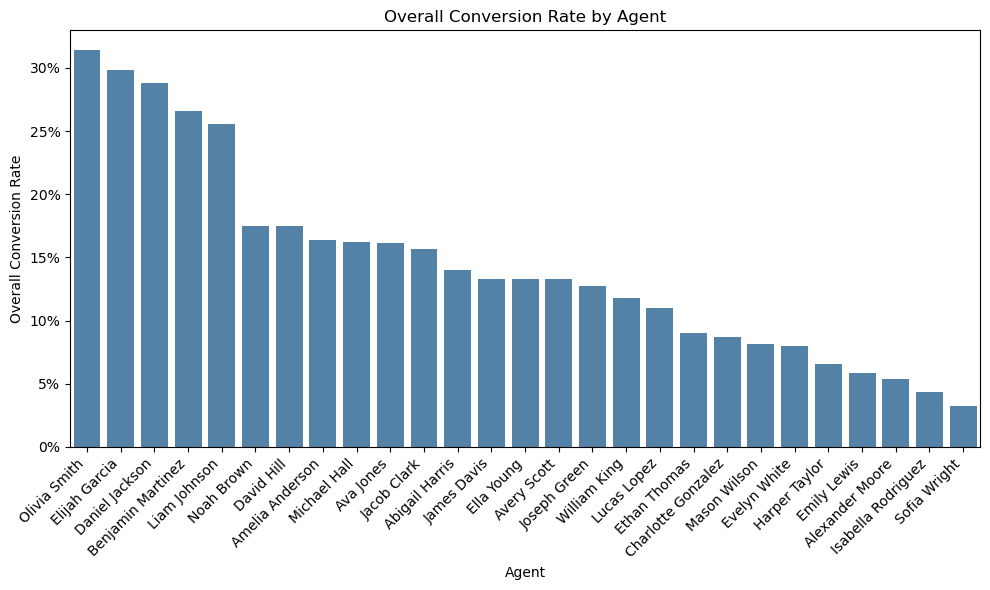

In [57]:
# Keep only the two columns we need and sort from lowest → highest
plot_df = (
    funnel[['overall_conv']]
    .sort_values('overall_conv', ascending=False)   # high to low
    .reset_index()                                 # agent names back to column
)

# ── 2️⃣  Draw the bar chart ────────────────────────────────────
plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    x='agent_name',
    y='overall_conv',
    color='steelblue'
)

# ── 3️⃣  Make it readable ─────────────────────────────────────
plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x:.0%}')  # y-axis as %
plt.xticks(rotation=45, ha='right')
plt.ylabel('Overall Conversion Rate')
plt.xlabel('Agent')
plt.title('Overall Conversion Rate by Agent')
plt.tight_layout()
plt.savefig('figures/conversion_by_agent_effectiveness.png', dpi=300)
plt.show()

Insight: Conversion rates vary widely by agent — from over 30% to below 5%. Top performers like Olivia Smith and Elijah Garcia are converting at more than 4× the rate of agents at the bottom of the chart. This suggests that individual sales techniques or follow-up strategies may significantly impact outcomes, and best practices from high performers could be leveraged to improve team-wide results.

### Compared to Total Applications by Agent Visual

<img src="figures/total_apps_vs_tenure_agent.png" width="80%">

| Top 5 by Conversion Rate (Efficiency)       | Top 5 by Total Applications       |
|---------------------------------------------|-----------------------------------|
| Olivia Smith (31%, 103 apps)                | Benjamin Martinez (112 apps, 27%)|
| Elijah Garcia (30%, 80 apps)                | Noah Brown (110 apps, 18%)       |
| Daniel Jackson (29%, 95 apps)               | Olivia Smith (103 apps, 31%)     |
| Benjamin Martinez (27%, 112 apps)           | Amelia Anderson (101 apps, 16%)  |
| Liam Johnson (26%, 33 apps) *(not in top 12)| Daniel Jackson (95 apps, 29%)    |

### Spotlight: Liam Johnson – High Efficiency, Low Volume
Although Liam Johnson does not appear among the top agents by total applications submitted (ranking 15th with 33 apps), he ranks 5th in overall conversion rate, converting 26% of his leads into applications.

This suggests that:

 * He is highly effective with the leads he receives
* His time and outreach are well-targeted
* He may be underutilized or handling fewer leads relative to others

---

 Liam is a strong example of efficiency over volume — a potential high performer if given more opportunities or lead flow.

 ---

In [63]:
comparison = (
    funnel[['applications', 'overall_conv']]
    .sort_values('applications', ascending=False)
    .style.format({
        'applications': '{:,}',
        'overall_conv': '{:.0%}'
    })
)

comparison

,applications,overall_conv
agent_name,,
Benjamin Martinez,112,27%
Noah Brown,110,18%
Olivia Smith,103,31%
Amelia Anderson,101,16%
Daniel Jackson,95,29%
Elijah Garcia,80,30%
Lucas Lopez,59,11%
Ava Jones,56,16%
Jacob Clark,46,16%


#### Some agents with lower total application counts actually have higher conversion rates. That suggests they're highly efficient — possibly making better use of their lead pool.

## Velocity Metrics by Agent (Excel-Based)

**Note** → Velocity KPIs are based on **successful journeys** only — leads that were contacted and ultimately resulted in a submitted application.

During velocity analysis, I encountered difficulties filtering out negative time_to_app values in Python due to inconsistencies in timestamp alignment across merged data. After exploring several options, I pivoted to Excel, where I could more easily inspect and filter the data manually.Sometimes the most effective path is the one that removes friction. While I plan to revisit this logic in Python, Excel allowed me to maintain momentum and surface the insights that mattered.

This allowed me to:

- Validate lead progression paths across funnel stages
- Focus on full conversions with clean, positive time intervals
- Prioritize insight over perfection — especially in identifying why top agents were performing better



## Velocity KPI Methodology 
To analyze the speed of agent activity through the sales funnel, I calculated three key velocity metrics using Excel:
- Time to Contact – how long it takes an agent to reach out after a lead is created
- Time to Quote – the delay between initial contact and when the quote is provided
- Time to Application – the time from quote to final application submission

These were calculated using timestamp differences across the cleaned and aligned datasets.

### Velocity KPI- Key Steps:
- Cleaned lead_id and product_name fields across all datasets to handle hidden characters (e.g., non-breaking spaces)
- Aligned timestamps for each funnel stage (lead_creation_date, contact_timestamp, quote_created_date, submitted_timestamp)
- Created a composite key (lead_id_product) by concatinating lead_id with the product name to track a lead's journey by product.  
        - One lead could receive multiple quotes for different products — this ensured attribution was accurate when evaluating agent performance
- Removed any records with negative or invalid time differences
- Filtered for fully converted records (those appearing in contact, quote, and application datasets)

### Aggregation:
For each agent, I calculated the average:
- time_to_contact
- time_to_quote
- time_to_app

### Output:
- Built labeled pivot tables in Excel showing each agent’s average velocity at each stage
- Categorized agents qualitatively (e.g., "responds quickly", "quotes instantly") to aid interpretation
- Compared these results with agents' funnel conversion performance (maintained separately in Python)
- While this part of the analysis was conducted in Excel for speed and visibility, the results were used to help explain observed differences in agent performance and conversion behavior.


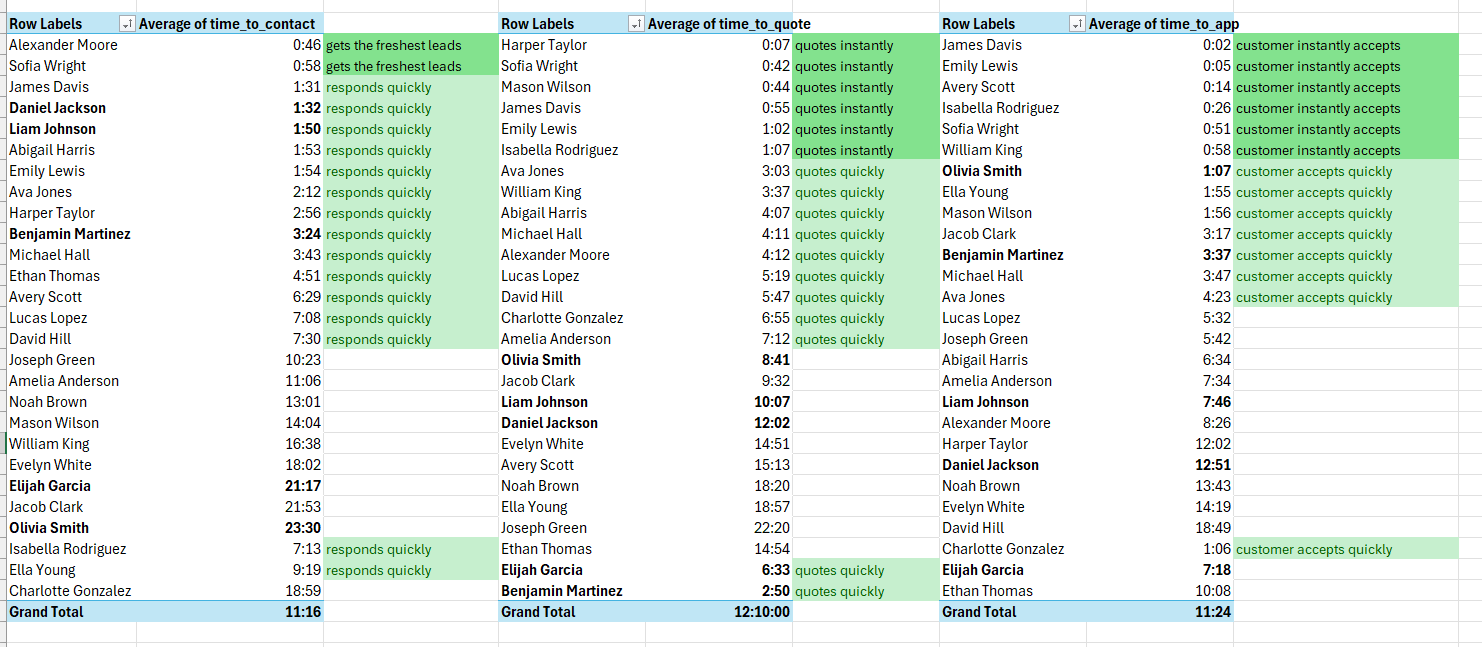

### Insight: moving too quickly can result in lower submitted applications.
Sofia Wright and Emily Lewis are among the fastest agents across all stages and their conversion rates are low.  James Davis is also fast, but only lands in the middle on overall performance.

In contrast, agents like Olivia Smith, Daniel Jackson and Liam Johnson show slower funnel velocity but stronger conversion rates. This suggests they may be spending more time helping clients understand their options. Their approach likely reflects stronger product knowledge and customer service skills — a reminder that speed alone doesn’t drive results; thoughtful, informed interactions matter too.

## Product Mix and Top 5 Analysis

### Coorelation between quotes and applications visual
Do more quotes lead to more applications?

Pearson r = 0.91  (p = 2.72e-11)


/tmp/ipykernel_12424/699356659.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


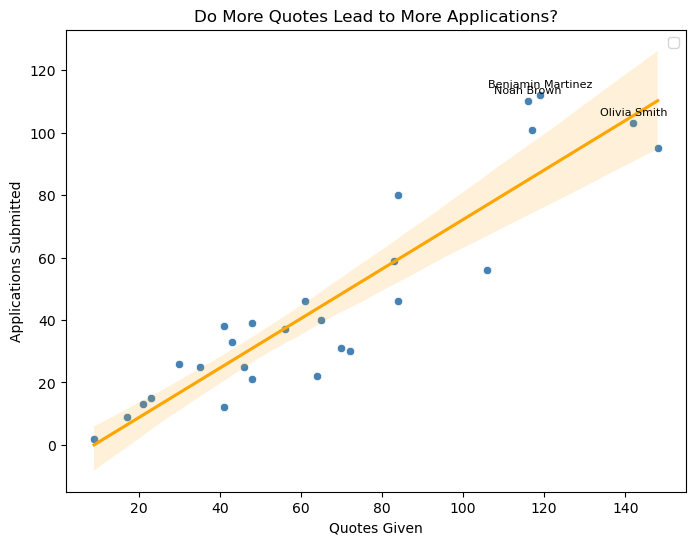

,agent_name,quotes,applications,quote_to_app_rate
4,Elijah Garcia,84,80,95%
2,Noah Brown,116,110,95%
7,Benjamin Martinez,119,112,94%
21,Ella Young,41,38,93%
12,Ethan Thomas,30,26,87%
11,Amelia Anderson,117,101,86%
25,Avery Scott,48,39,81%
1,Liam Johnson,43,33,77%
18,Jacob Clark,61,46,75%
0,Olivia Smith,142,103,73%


In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# ── 1 Counts per agent ─────────────────────────────────────────
quote_cnt = quotes.groupby('agent_id').size().rename('quotes')
app_cnt = apps.groupby('agent_id').size().rename('applications')

quote_vs_app = (
    pd.concat([quote_cnt, app_cnt], axis=1).fillna(0).astype(int)
      .merge(agents[['agent_id', 'agent_name']], on='agent_id', how='left')
      .assign(quote_to_app_rate=lambda d: d['applications'] / d['quotes'].replace(0, pd.NA))
)

# ── 2 Correlation (quotes ↔ applications) ─────────────────────
r, p = pearsonr(quote_vs_app['quotes'], quote_vs_app['applications'])
print(f"Pearson r = {r:.2f}  (p = {p:.3g})")

# ── 3 Scatter plot ────────────────────────────────────────────
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    data=quote_vs_app,
    x='quotes',
    y='applications',
    color='steelblue'
)
sns.regplot(data=quote_vs_app, x='quotes', y='applications',
            scatter=False, ax=ax, color='orange',
            line_kws={'label': f'r = {r:.2f}'})

# optional labels for top performers
for _, row in quote_vs_app.nlargest(3, 'applications').iterrows():
    plt.text(row['quotes'], row['applications']+2, row['agent_name'],
             ha='center', va='bottom', fontsize=8)

plt.xlabel('Quotes Given')
plt.ylabel('Applications Submitted')
plt.title('Do More Quotes Lead to More Applications?')
plt.legend()
plt.savefig('figures/coor_quotes_to_app.png', dpi=300)
plt.show()

# ── 4 Quick look at conversion efficiency (optional table) ────
display(
    quote_vs_app[['agent_name', 'quotes', 'applications', 'quote_to_app_rate']]
    .sort_values('quote_to_app_rate', ascending=False)
    .head(10)   # top 10 converters
    .style.format({'quote_to_app_rate': '{:.0%}', 'quotes': '{:,}', 'applications': '{:,}'})
)

Insight: If an agent successfully delivers a quote, it significantly increases their chances of submitting an application.  

### Quotes by Product and Agent

In [60]:
# Clean product names
quotes['product_key'] = quotes['product_name'].str.strip().str.lower()

# Raw tall table: one row = an agent-product pair with the quote count
quotes_by_prod_agent = (
    quotes.groupby(['agent_id', 'product_key'])
          .size()
          .reset_index(name='quote_count')
          .merge(agents[['agent_id', 'agent_name']], on='agent_id', how='left')
          .sort_values(['agent_name', 'product_key'])
)

# List of target agent names (case-exact as in agents['agent_name'])
top_agents = [
    'Olivia Smith',
    'Elijah Garcia',
    'Daniel Jackson',
    'Benjamin Martinez',
    'Liam Johnson'
]

# Ensure you already built `quotes_by_prod_agent` as in the previous step
filtered = quotes_by_prod_agent[
    quotes_by_prod_agent['agent_name'].isin(top_agents)
].sort_values(['agent_name', 'product_key'])

filtered.head(10)

,agent_id,product_key,quote_count,agent_name
18,656816,dental vision hearing,10,Benjamin Martinez
19,656816,medicare advantage,107,Benjamin Martinez
20,656816,medicare supplement,2,Benjamin Martinez
39,657309,dental vision hearing,45,Daniel Jackson
40,657309,medicare advantage,102,Daniel Jackson
41,657309,medicare supplement,1,Daniel Jackson
11,656390,dental vision hearing,5,Elijah Garcia
12,656390,medicare advantage,79,Elijah Garcia
3,655592,dental vision hearing,8,Liam Johnson
4,655592,medicare advantage,34,Liam Johnson


### Quote Distribution by Product and Top 5 Agents

In [61]:
# 1) total quotes per product for everyone
totals = quotes_by_prod_agent.groupby(
    'product_key')['quote_count'].sum().rename('team_total')

# 2) top-5 subset
top_agents = [
    'Olivia Smith', 'Elijah Garcia', 'Daniel Jackson',
    'Benjamin Martinez', 'Liam Johnson'
]
top5 = quotes_by_prod_agent[quotes_by_prod_agent['agent_name'].isin(
    top_agents)]
top5_tot = top5.groupby('product_key')[
    'quote_count'].sum().rename('top5_total')

# 3) everyone-else subset
rest_tot = (totals - top5_tot).rename('rest_total').fillna(0).astype(int)

# 4) combine into one tidy table
compare_tbl = (
    pd.concat([totals, top5_tot, rest_tot], axis=1)
      .fillna(0).astype(int)
      .assign(top5_pct=lambda d: d['top5_total'] / d['team_total'])
      .round(2)
      .reset_index()
      .rename(columns={'product_key': 'product'})
)

compare_tbl.style.format({'team_total': '{:,}',
                          'top5_total': '{:,}',
                          'rest_total': '{:,}',
                          'top5_pct':   '{:.0%}'})

,product,team_total,top5_total,rest_total,top5_pct
0,dental vision hearing,364,77,287,21%
1,medicare advantage,"1,390",435,955,31%
2,medicare supplement,35,24,11,69%


### Application Distribution by Product and Top 5 Agents

In [62]:
# Clean product names if not done yet
apps_with_names['product_key'] = apps_with_names['product_name'].str.strip(
).str.lower()

# Step 1: Total applications per agent per product
app_counts = (
    apps_with_names.groupby(['agent_name', 'product_key'])
    .size()
    .reset_index(name='app_count')
)

# Step 2: Define your top 5 agents
top_agents = [
    'Olivia Smith',
    'Elijah Garcia',
    'Daniel Jackson',
    'Benjamin Martinez',
    'Liam Johnson'
]

# Step 3: Flag whether each row is a top 5 agent
app_counts['agent_group'] = app_counts['agent_name'].apply(
    lambda x: 'top5' if x in top_agents else 'rest'
)

# Step 4: Group by product and agent group to get totals
grouped = (
    app_counts.groupby(['product_key', 'agent_group'])['app_count']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

# Step 5: Add total + % columns
grouped['team_total'] = grouped['top5'] + grouped['rest']
grouped['top5_pct'] = (
    grouped['top5'] / grouped['team_total']).apply(lambda x: f"{x:.0%}")

# Optional: Rename columns for clarity
grouped = grouped.rename(columns={
    'product_key': 'product',
    'top5': 'top5_total',
    'rest': 'rest_total'
})

# Final result
grouped = grouped[['product', 'team_total',
                   'top5_total', 'rest_total', 'top5_pct']]

# Preview
print(grouped)

agent_group                product  team_total  top5_total  rest_total  \
0            dental vision hearing         192          48         144   
1               medicare advantage        1026         367         659   
2              medicare supplement           8           8           0   

agent_group top5_pct  
0                25%  
1                36%  
2               100%  


### Quote and Application Summary

The top 5 agents 
- Dominated Medicare Supplement across the funnel. They created 69% of all Medicare Supplement applications and submitted 100% of applications.
- Account for a large portion of Medicare Advantage Applications. They represent 17% of the team, but account for 31% of MA quotes and 36% of MA applications. The remaining 83% of agents generate 69% of MA quotes and 64% of MA applications.
- Quote Dental Vision Hearing far less often

### Top 5 Agents vs. Team Totals
#### Quote Distribution by Product

| Product                 | Team Total | Top 5 Total | Rest Total | Top 5 % |
|-------------------------|------------|-------------|------------|---------|
| Dental Vision Hearing   | 364        | 77          | 287        | 21%     |
| Medicare Advantage      | 1,390      | 435         | 955        | 31%     |
| Medicare Supplement     | 35         | 24          | 11         | 69%     |

#### Applications Distribution by Product

| Product                | Team Total | Top 5 Total | Rest Total | Top 5 % |
|------------------------|------------|-------------|------------|---------|
| Dental Vision Hearing  | 192        | 48          | 144        | 25%     |
| Medicare Advantage     | 1,026      | 367         | 659        | 36%     |
| Medicare Supplement    | 8          | 8           | 0          | 100%    |


## Key Insights and Recommendations

### What do you consider the most important key performance indicator (KPI), and why?		
Since we are analyzing the performace of insurance agents, I'd say conversion rate is the most important performance indicator.  It reflects how efficiently an agent turns leads into applications, which directly impacts revenue.  A high lead volume is helpful, but if it doesn't convert, it just adds cost.  Conversion gives us a clear view of effectiveness, not just activity.				


### Who are the top performers and what are the key factors contributing to their success?	
Olivia Smith, Elijah Garcia, Daniel Jackson, Benjamin Martinez and Liam Johnson
- Successful agents take their time to explain products to customers without rushing.
- In Medicare Supplement, a much smaller market, they write 69% of all quotes, which shows product expertise.
- High quote output with focused effort.
- Together, they generate 31% of all Medicare Advantage quotes.
- Exceptional quote-to-application conversion.
- They also contribute 69% of all Medicare Supplement quotes, showing niche expertise.
- Three of the five are tenured; two are at ramp 2, yet already outperform. This indicates a blend of product knowledge (tenured) and fresh energy (ramp). However, we’ve shown that this is not highly predictive of success as an agent.


### What strategies should we implement to increase production?

- **Replicate quoting behaviors of top performers**  
  The top 5 agents quote significantly more per lead. Use call reviews or job shadowing to identify their approach to quoting and share best practices.
  Emphasize empathy or rapport-bulding during contact.
  Encourage asking more open-ended questions before quoting and not rushing.

 - **Medicare Supplement**  
  Elevate training for non–Top-5 agents; even a small lift (e.g., 5 more quotes each) would double team volume.  

- **Close feedback loop between quoting and conversions**  
  Agents with high quote → app rates may be selecting better product fits. Provide reporting to all agents showing their conversion rates by product.
  Performance Dashboards- show speed vs conversion side by side, highlight agents with balanced performance

- **Reward consistent high-quota engagement**  
  Rather than only recognizing top apps, consider quota-based contests that reward quote volume *and* efficiency in conversion.

- **Enhance support during early ramp months**  
  Some high performers emerged as early ramp agents. Focused mentorship or pairing with tenured reps may accelerate learning curves.

- **Enhance support during early ramp months**  
  Some high performers emerged as early ramp agents. Focused mentorship or pairing with tenured reps may accelerate learning curves.

- **Uncontacted Leads**  
  While the application rate among quoted leads is strong (68%), the overall conversion rate is just 1%, driven primarily by a low contact rate (7%). This suggests that the greatest opportunity lies in improving outreach — increasing the number of leads successfully contacted could significantly boost overall production.

 - **Dental Vision Hearing** 
  Why do they quote DVH so rarely? Is it lower commission, script gaps, or confidence?
  

### Future Consideration – Lead Source Quality
- While this analysis focused on agent performance and funnel velocity, it’s worth exploring whether certain lead sources consistently generate higher-converting leads.
- Differences in performance could be partially explained by variations in lead quality rather than rep behavior alone.
- I recommend a follow-up analysis to evaluate conversion rate by lead source, as this could inform marketing strategy and lead routing.

### Summary of Key Takeaways
- Top agents convert 26–31% of their leads into applications and account for 100% of Medicare Supplement applications.
- Application conversion drops steeply due to a 7% contact rate.
- Speedy contact doesn’t always yield better outcomes.
- Consider further analysis of lead source quality and distribution strategy.
